In [2]:
!python3 -m pip install -U scikit-learn

     |████████████████████████████████| 8.5 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 13.8 MB/s eta 0:00:01
You should consider upgrading via the '/Users/otaniels/.pyenv/versions/3.10.1/bin/python3 -m pip install --upgrade pip' command.


In [11]:
"""Copyright © by Boston Consulting Group. All rights reserved."""
import datetime
import logging
from pathlib
from typing import Any, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics
from tqdm import tqdm
from sklearn.metrics import auc, roc_curve

pd.set_option('display.max_columns', None)

In [9]:
base_path = pathlib.Path().resolve().parent
data_path = base_path / 'data'
sample_data_loc = data_path / 'test_sample.csv'
df_sample = pd.read_csv(sample_data_loc)

In [48]:
def create_binary_target_plots(
    df: pd.DataFrame,
    target_col: str,
    feature_col: str,
    n_bins: int = 10,
    min_feature_val: float = None,
    max_feature_val: float = None,
    min_feature_q: float = None,
    max_feature_q: float = None,
    create_plot=True,
    invert_xaxis=False,
    use_quantiles: bool = True,
    fillna: bool = False
) -> Tuple[Union[pd.DataFrame, None], Union[plt.figure, None]]:
    """Creates three plots for univariate analysis for binary targets.
    :param df: Input data frame
    :param target_col: Column name of target variable
    :param feature_col: List of column names contained in df.
    :param n_bins: Number of bins
    :param min_feature_val: Lower feature value at which to
        winsorize (only applied to numerical columns).
    :param max_feature_val Upper feature value at which to
        winsorize (only applied to numerical columns).
    :param min_feature_q: Lower quantile at which to
        winsorize (only applied to numerical columns).
    :param max_feature_q: Upper quantile at which to
        winsorize (only applied to numerical columns).
    :param create_plot: Determines whether figure will be plotted.
    :param use_quantiles: Whether to use quantiles for event rate bins.
    :return: -> Dataframe containing feature and target metrics and figure:
    """

    # Ensure columns exist
    # pd_check_cols_in_df(df, col_list=[feature_col, target_col], raise_flag=True)

    if df[feature_col].nunique() < 2:
        _logger.info("Feature contains less than 2 features!")
        return None, None

    # Ensure target contains no NA values
    if df[target_col].isna().sum() > 0:
        raise ValueError("Target column contains NA values!")

    # Ensure target is binary
    if df[target_col].nunique() != 2:
        raise ValueError("Target variable is not binary!")

    # Ensure min/max values are in correct order
    if (
        min_feature_val is not None
        and max_feature_val is not None
        and min_feature_val >= max_feature_val
    ):
        raise ValueError(
            "min_feature_value must be strictly smaller than max_feature_val!"
        )
    elif (
        min_feature_q is not None
        and max_feature_q is not None
        and min_feature_q >= max_feature_q
    ):
        raise ValueError("min_feature_q must be strictly smaller than max_feature_q!")
    elif min_feature_q is not None and min_feature_q < 0:
        raise ValueError("Quantiles must be values between 0 and 1!!")
    elif max_feature_q is not None and max_feature_q < 0:
        raise ValueError("Quantiles must be values between 0 and 1!!")

    # Create fresh copy of dataframe
    df = df.copy()
    
    #if fillna == True:
    #        df = df.copy()
    #        df.loc[df[feature_col].isin([-np.inf, np.inf, np.nan]), feature_col] = df.loc[~df[feature_col].isin([-np.inf, np.inf, np.nan]), feature_col].median()

    # Calculate global event rate
    event_rate = np.mean(df[target_col])

    # Case 1: At most n_bins elements
    if df[feature_col].nunique() < n_bins:

        # Extract unique values
        unique_vals = df[feature_col].sort_values().unique()

        # Convert sorted elements to int
        mapping = pd.factorize(unique_vals, na_sentinel=len(unique_vals))

        # Create mapping
        mapping_values = list(mapping[0])
        mapping_keys = list(mapping[1])

        # Create mapping dictionary
        mapping_dict = dict(zip(mapping_keys, mapping_values))

        # Apply mapping to column
        df = df.assign(bins=df[feature_col].map(mapping_dict))

        # Set labels for plotting
        labels = mapping_keys

    # Case 2: More than n_bins elements and categorical
    elif (not pd.api.types.is_numeric_dtype(df[feature_col])) and (
        df[feature_col].nunique() >= n_bins
    ):
        _logger.info(
            f"--- Number of unique elements ({df[feature_col].nunique()} "
            f"exceeds n_bins ({n_bins})). "
            f"Increase n_bins to create a plot!"
        )
        return None, None

    # Case 3: More than n_bins elements and numerical
    elif pd.api.types.is_numeric_dtype(df[feature_col]):
        
        print("currently here!")

        # Extract number of unique values
        n_unique_feat_vals = df[feature_col].nunique()
        print(f"n_unique_feat_vals: {n_unique_feat_vals}") # 48

        # Adjust n_bins is less unique values exist
        n_bins = np.minimum(n_unique_feat_vals, n_bins)
        print(f"n_bins: {n_bins}") # min(48, 10) = 10

        min_val = np.nanmin(df[feature_col])
        max_val = np.nanmax(df[feature_col])
        print(f"min: {min_val}, max: {max_val}")
        
        # override min and max if quantiles passed to f'n
        if min_feature_q is not None:
            min_val = np.nanquantile(df[feature_col], min_feature_q)

        if max_feature_q is not None:
            max_val = np.nanquantile(df[feature_col], max_feature_q)

        if min_feature_val is not None:
            min_val = np.maximum(min_val, min_feature_val)

        if max_feature_val is not None:
            max_val = np.minimum(max_val, max_feature_val)
        
        # get min & max excluding +/- inf
        idx_neg_inf = df[feature_col] == -np.inf
        idx_pos_inf = df[feature_col] == np.inf
        min_val_excl_inf = np.nanmin(df[feature_col][~idx_neg_inf])
        max_val_excl_inf = np.nanmax(df[feature_col][~idx_pos_inf])

        min_val_adj = np.maximum(min_val, min_val_excl_inf)
        max_val_adj = np.minimum(max_val, max_val_excl_inf)

        # Create equidistant grid
        if use_quantiles:
            print('using quantiles')
            
            # using unique ensures that when quantiles are the same they are not used twice
            bins = np.unique(
                df[feature_col]
                .clip(min_val_adj, max_val_adj)
                .quantile(np.linspace(0, 1, n_bins))
            )
            print(bins)
            n_bins = len(bins)
        else:
            print('not using quantiles')
            bins = np.linspace(min_val_adj, max_val_adj, n_bins)
    
        
        print(f"bins before updating: {bins}")
        bins[0] = min_val
        bins[n_bins - 1] = max_val
        print(f"bins after updating: {bins}")

        # Clip values according to min/max values
        df[feature_col].clip(lower=min_val, upper=max_val, inplace=True)

        # Ensure clipping values does not remove all but a single value
        if df[feature_col].nunique() < 2:
            _logger.info(
                "Feature contains less than 2 features after clipping outliers!!"
            )
            return None, None

        # Create bins (return None if binning is not successfull)
        try:
            
            # create new column indicating what bin record belongs to
            df = df.assign(
                bins=pd.cut(
                    x=df.loc[:, feature_col],
                    bins=bins,
                    include_lowest=True,
                    right=True,
                    labels=False,
                )
            )
        except Exception as e:
            _logger.warning(e)
            return None, None
        
        # Create plot labels: [(4, 6), (6, 10), ...]
        bins = list(bins)
        labels = [
            f'({"{:,.2f}".format(bins[i])}, {"{:,.2f}".format(bins[i+1])}]'
            for i in range(n_bins - 1)
        ]
        print(labels)

        # Handle NAs
        if df["bins"].isna().sum() > 0:
            
            # replace the NA bin w/ n_bins - 1
            df.loc[:, "bins"] = df.loc[:, "bins"].where(
                ~df.loc[:, "bins"].isna(), n_bins - 1
            )
            labels.append("NA")
            n_bins += 1

        # Convert bins to categories
        df.bins = df.bins.astype("category")

        # Set all categories
        df.bins = df.bins.cat.set_categories(list(range(n_bins - 1)))

    # Group into bins and calculate required metrics
    df_binned = df.groupby("bins").agg({feature_col: [len], target_col: ["mean"]})
    print(df_binned)

    # Rename columns
    level_one = df_binned.columns.get_level_values(0).astype(str)
    level_two = df_binned.columns.get_level_values(1).astype(str)
    column_separator = ["_" if x != "" else "" for x in level_two]
    print(level_one + column_separator + level_two)
    df_binned.columns = level_one + column_separator + level_two
    print(df_binned)


    # Set NA counts to zero
    df_binned[f"{feature_col}_len"] = df_binned[f"{feature_col}_len"].fillna(0)

    # Add lift rate
    df_binned.loc[:, "lift_rate"] = np.divide(
        df_binned[f"{target_col}_mean"], event_rate
    )

    # Build plots dependent on feature type
    if not pd.api.types.is_numeric_dtype(df[feature_col]):

        grid = plt.GridSpec(1, 6, wspace=1.2, hspace=0.2)
        fig_grid = plt.figure(figsize=(18, 12))
        fig_grid.suptitle(f"{feature_col}: Event Rates", fontsize=20)

    else:

        grid = plt.GridSpec(2, 6, wspace=1.2, hspace=0.2, height_ratios=[2, 2])
        fig_grid = plt.figure(figsize=(14, 9))
        fig_grid.suptitle(
            f"{feature_col}: Roc Curve | Densities | Event Rates", fontsize=20
        )
        
        if fillna == True:
            df_imputed = df.copy()
            df_imputed.loc[df_imputed[feature_col].isin([-np.inf, np.inf, np.nan]), feature_col] = df_imputed.loc[~df_imputed[feature_col].isin([-np.inf, np.inf, np.nan]), feature_col].median()
            
        else:
            df_imputed = df.loc[~df[feature_col].isin([-np.inf, np.inf, np.nan])]
        fpr, tpr, _ = metrics.roc_curve(
            df_imputed[target_col], -df_imputed[feature_col], pos_label=1
        )
        auc = metrics.auc(fpr, tpr)
        if auc < 0.5:
            fpr, tpr, _ = metrics.roc_curve(
                df_imputed[target_col], df_imputed[feature_col], pos_label=1
            )
            auc = metrics.auc(fpr, tpr)

        # Build Roc-Curve plot
        upper_ax_left = fig_grid.add_subplot(grid[0, 0:3])
        if pd.api.types.is_numeric_dtype(df[feature_col]):
            upper_ax_left.plot(
                fpr, tpr, lw=2, label=f"{feature_col} (area = {auc:.3f})"
            )

        upper_ax_left.plot([0, 1], [0, 1], color="lightgrey", lw=1, linestyle="--")
        upper_ax_left.set_xlim([0.0, 1.0])
        upper_ax_left.set_ylim([0.0, 1.05])
        upper_ax_left.set_xlabel("Cumulated goods")
        upper_ax_left.set_ylabel("Cumulated bads")
        upper_ax_left.legend(loc="lower right")

        # Build density plot
        upper_ax_right = fig_grid.add_subplot(grid[0, 3:6])

        sns.kdeplot(
            data=df,
            x=feature_col,
            hue=target_col,
            log_scale=False,
            fill=True,
            cumulative=False,
            common_norm=False,
            ax=upper_ax_right,
            clip=(df[feature_col].quantile(0.01), df[feature_col].quantile(0.99))
        )
        if all(df[feature_col] > 0):
            upper_ax_right.set_xscale("log")

    # Build event rate plot
    if pd.api.types.is_numeric_dtype(df[feature_col]):
        lower_ax = fig_grid.add_subplot(grid[1, :])
    else:
        lower_ax = fig_grid.add_subplot(grid[0, :])

    # Add ticks & laels to axis
    lower_ax.set_xlabel(feature_col)
    lower_ax.set_ylabel("# Observations")
    lower_ax.set_xticks(df_binned.index)
    lower_ax.set_xticklabels(labels, rotation=90)

    # Plot barplot containing number of observations
    lower_ax.bar(df_binned.index, df_binned[f"{feature_col}_len"], color="lightgray")

    lower_ax.yaxis.grid(False)

    # Mirror plot and add event rates
    lower_ax_2 = lower_ax.twinx()
    lower_ax_2.set_ylabel("Event rate")
    lower_ax_2.set_ylim(ymin=0, ymax=df_binned[f"{target_col}_mean"].max() + 0.1)
    plt.yticks(np.arange(0, df_binned[f"{target_col}_mean"].max() + 0.1, step=0.1))
    lower_ax_2.plot(
        df_binned.index, df_binned[f"{target_col}_mean"], label="event_rate", marker="o"
    )

    # Add global event rate as baseline
    lower_ax_2.plot(
        [min(df_binned.index) - 1, max(df_binned.index) + 1],
        [event_rate, event_rate],
        color="darkgrey",
        lw=1,
        linestyle="--",
        label=f"total_event_rate\n({'{:.1%}'.format(event_rate)})",
    )
    lower_ax_2.legend(loc=0)
    lower_ax_2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

    lower_ax_2.yaxis.grid(False)
    lower_ax_2.set_xlim([min(df_binned.index) - 0.5, max(df_binned.index) + 0.5])

    if invert_xaxis:
        lower_ax_2.invert_xaxis()

    if create_plot:
        plt.show()

    return df_binned, fig_grid

In [49]:
df_sample

,CUSTOMER_ID,REF_DATE,DATE,PHYSICAL_STATE,PHYSICAL_CITY,PHYSICAL_POSTAL_CODE,A_TENURE_MONTHS_N,A_TENURE_GROUP_C,A_YEARS_IN_BUSINESS_N,A_NUMBER_OF_DRIVERS_N,A_NUMBER_OF_EMPLOYEES_N,A_NUMBER_OF_TRUCKS_N,FRAUD_FLAG_FP,FRAUD_FLAG_OPERATIONS,THIN_FILE_INDICATOR,SELF_REPORTED_INDICATOR,HAS_PARENT,PLATFORM,D_N_DELINQUENCIES_6M_N,D_N_DELINQUENCIES_1M_N,D_MAX_DAYS_PAST_DUE_6M_N,D_MAX_DAYS_PAST_DUE_1M_N,D_DAYS_PAST_DUE_CURRENT_N,D_DAYS_SINCE_LAST_30DPD_CURRENT_N,DNB_FAILURE_SCORE_N,DNB_DELINQUENCY_SCORE_N,LN_LEXISNEXIS_SCORE_CURRENT_N,LN_LEXISNEXIS_SBFE_SCORE_CURRENT_N,LN_LEXISNEXIS_THIN_FILE_FLAG_B,LN_LIMITED_CREDIT_HISTORY_FLAG_B,BUSINESS_DATE_NEXT_60_DPD,DAYS_UNTIL_NEXT_60_DPD,EXPOSURE_NEXT_60_DPD,FLAG_60_DPD_366_DAYS,MC_MON_AMT_USED_FLAG_6M_C,T_SUM_GALLONS_1M,T_TRX_AMT_TOTAL_TREND42_N,T_AVG_TRX_AMT_6M_N,T_SPREAD_SUM_GALLONS_6M_N,T_SPREAD_GROSS_SPEND_6M_N,T_TOTAL_TRX_NON_FUEL_PROPORTION_1M_N,T_PPG_AVG_1M_N,T_PPG_AVG_3M_N,T_PPG_AVG_6M_N,T_TREND_SUM_TRX_AMT_6M_N,T_TREND_SUM_GALLONS_6M_N,T_AVG_SPOT_RATE_1M_N,T_AVG_SPOT_RATE_3M_N,T_AVG_SPOT_RATE_6M_N,T_DXR_AVG_1M_N,T_DXR_AVG_3M_N,T_DXR_AVG_6M_N,FILTER_TRAIN,FILTER_PREDICT
0,788480,2020-09-01,2020-09-01 07:00:00+00:00,MO,COLUMBIA,65203,4,<5Y,NaN,2.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,EFSLLC,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1.0,0,NaN,NaN,NaN,0,0,1478.99,9.445751,186.707222,2.544645,2.504313,0.0,1.853650,1.927411,1.927411,7.928631,0.501942,1797.472551,1681.172343,1548.135357,0.001031,0.001146,0.001245,1,1
1,726329,2019-09-01,2019-09-01 07:00:00+00:00,FL,OCALA,34472,8,>5Y,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,EFSLLC,0,0,0,0,0,NaN,NaN,NaN,627.0,663.0,0.0,1,NaN,NaN,NaN,0,0,0.00,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1464.701085,1487.376517,1467.511230,NaN,NaN,NaN,1,1
2,723197,2018-09-01,NaN,NaN,NaN,NaN,4,>5Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,717.0,665.0,0.0,1,NaN,NaN,NaN,0,1,0.00,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1672.480401,1740.612115,1711.087525,NaN,NaN,NaN,1,1
3,731965,2020-03-01,2020-03-01 08:00:00+00:00,IL,TUSCOLA,61953,16,>5Y,NaN,2.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,EFSLLC,0,0,0,0,0,NaN,1445.0,584.0,699.0,734.0,0.0,1,NaN,NaN,NaN,0,0,1309.89,1.364412,471.156944,1.088859,1.094108,0.0,2.610021,2.675425,2.739997,5.710350,0.135656,1402.419633,1487.192250,1475.404310,0.001861,0.001799,0.001857,1,1
4,776183,2020-03-01,2020-03-01 08:00:00+00:00,VA,NEWPORT NEW,23602,5,<5Y,NaN,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,EFSLLC,0,0,0,0,0,NaN,1476.0,538.0,652.0,730.0,0.0,1,NaN,NaN,NaN,0,0,0.00,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1402.419633,1487.192250,1475.404310,NaN,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,721720,2020-03-01,2020-03-01 08:00:00+00:00,WI,JANESVILLE,53546,13,>5Y,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,EFSLLC,0,0,0,0,0,NaN,1471.0,588.0,718.0,811.0,0.0,1,NaN,NaN,NaN,0,0,1236.73,0.715000,595.677500,0.527334,0.619530,0.0,2.402521,2.561566,2.665015,4.742633,-0.022476,1402.419633,1487.192250,1475.404310,0.001713,0.001722,0.001806,1,1
996,758159,2021-03-01,2021-03-01 08:00:00+00:00,TX,HUMBLE,77396,25,<5Y,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,EFSLLC,0,0,0,0,0,NaN,1495.0,559.0,719.0,692.0,0.0,1,NaN,NaN,NaN,0,0,962.60,1.160468,474.547778,0.724382,0.767246,0.0,2.384480,2.199318,2.052218,5.379094,0.020668,2052.412726,2048.922855,2014.550954,0.001162,0.001073,0.001019,1,1
997,783592,2022-03-01,2022-03-01 08:00:00+00:00,OH,OLMSTED TWP,44138,24,<5Y,NaN,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,EFSLLC,0,0,0,0,0,NaN,NaN,NaN,736.0,782.0,0.0,1,NaN,NaN,NaN,0,0,1143.25,1.152823,1077.803333,1.426978,1.409503,0.0,3.487645,3.231800,3.237577,5.613892,0.113809,2635.383681,2611.483855,2585.541279,0.001323,0.001238,0.001252,1,1
998,798374,2022-03-01,2022-03-01 08:00:00+00:00,IN,KNOX,46534,17,<5Y,NaN,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,EFSLLC,0,0,0,0,0,NaN,39.0,80.0,678.

currently here!
n_unique_feat_vals: 48
n_bins: 10
min: 4, max: 61
using quantiles
[ 4.  6.  9. 11. 16. 20. 25. 31. 39. 61.]
bins before updating: [ 4.  6.  9. 11. 16. 20. 25. 31. 39. 61.]
bins after updating: [ 4.  6.  9. 11. 16. 20. 25. 31. 39. 61.]
['(4.00, 6.00]', '(6.00, 9.00]', '(9.00, 11.00]', '(11.00, 16.00]', '(16.00, 20.00]', '(20.00, 25.00]', '(25.00, 31.00]', '(31.00, 39.00]', '(39.00, 61.00]']
     A_TENURE_MONTHS_N FLAG_60_DPD_366_DAYS
                   len                 mean
bins                                       
0                  132             0.037879
1                  104             0.019231
2                   99             0.010101
3                  145             0.013793
4                   79             0.012658
5                  112             0.008929
6                  108             0.018519
7                  118             0.000000
8                  103             0.000000
Index(['A_TENURE_MONTHS_N_len', 'FLAG_60_DPD_366_DAYS_mean'], d

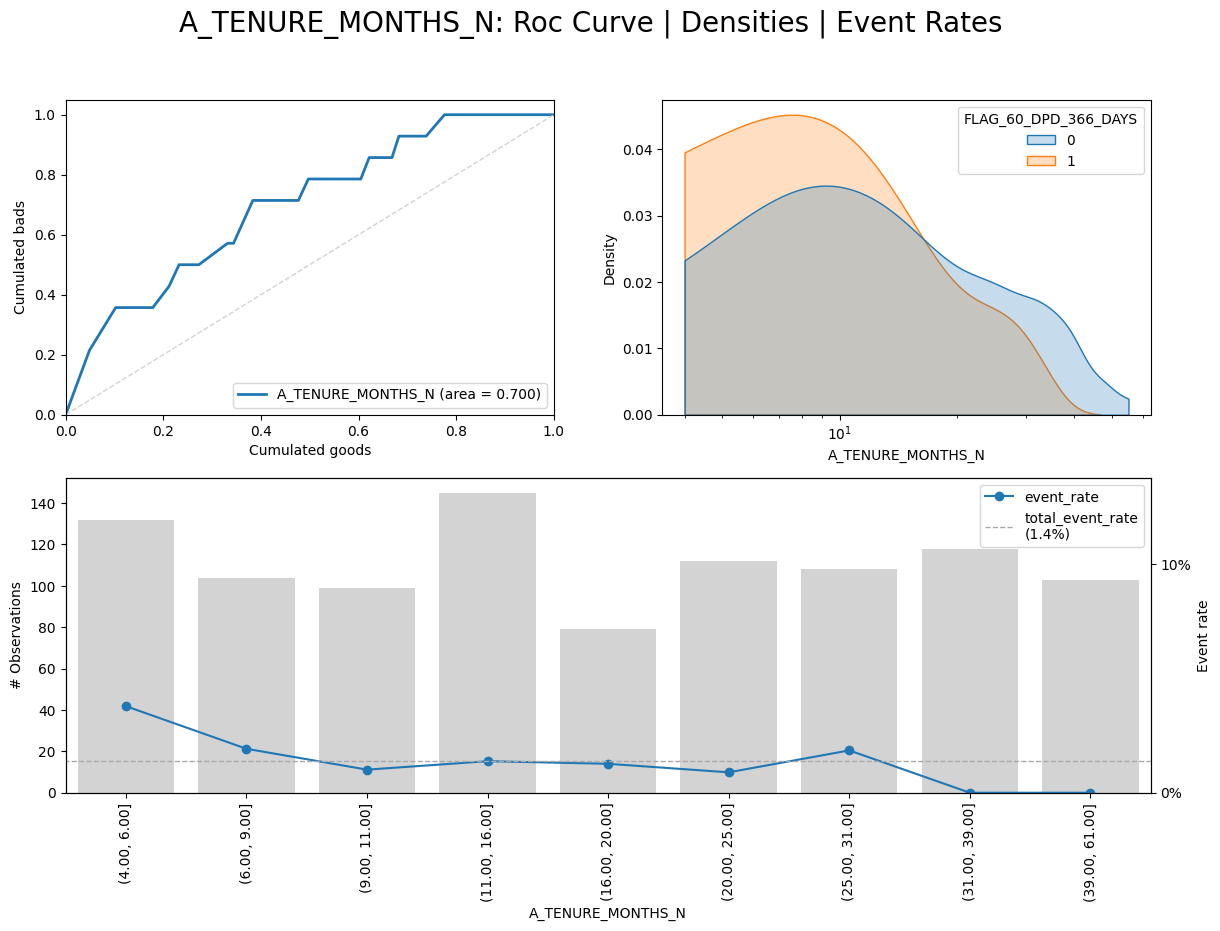

(      A_TENURE_MONTHS_N_len  FLAG_60_DPD_366_DAYS_mean  lift_rate
 bins                                                             
 0                       132                   0.037879   2.705628
 1                       104                   0.019231   1.373626
 2                        99                   0.010101   0.721501
 3                       145                   0.013793   0.985222
 4                        79                   0.012658   0.904159
 5                       112                   0.008929   0.637755
 6                       108                   0.018519   1.322751
 7                       118                   0.000000   0.000000
 8                       103                   0.000000   0.000000,
 <Figure size 1400x900 with 4 Axes>)

In [50]:
create_binary_target_plots(
    df = df_sample,
    target_col = "FLAG_60_DPD_366_DAYS",
    feature_col = "A_TENURE_MONTHS_N"
)

currently here!
n_unique_feat_vals: 27
n_bins: 10
min: 0, max: 134
not using quantiles


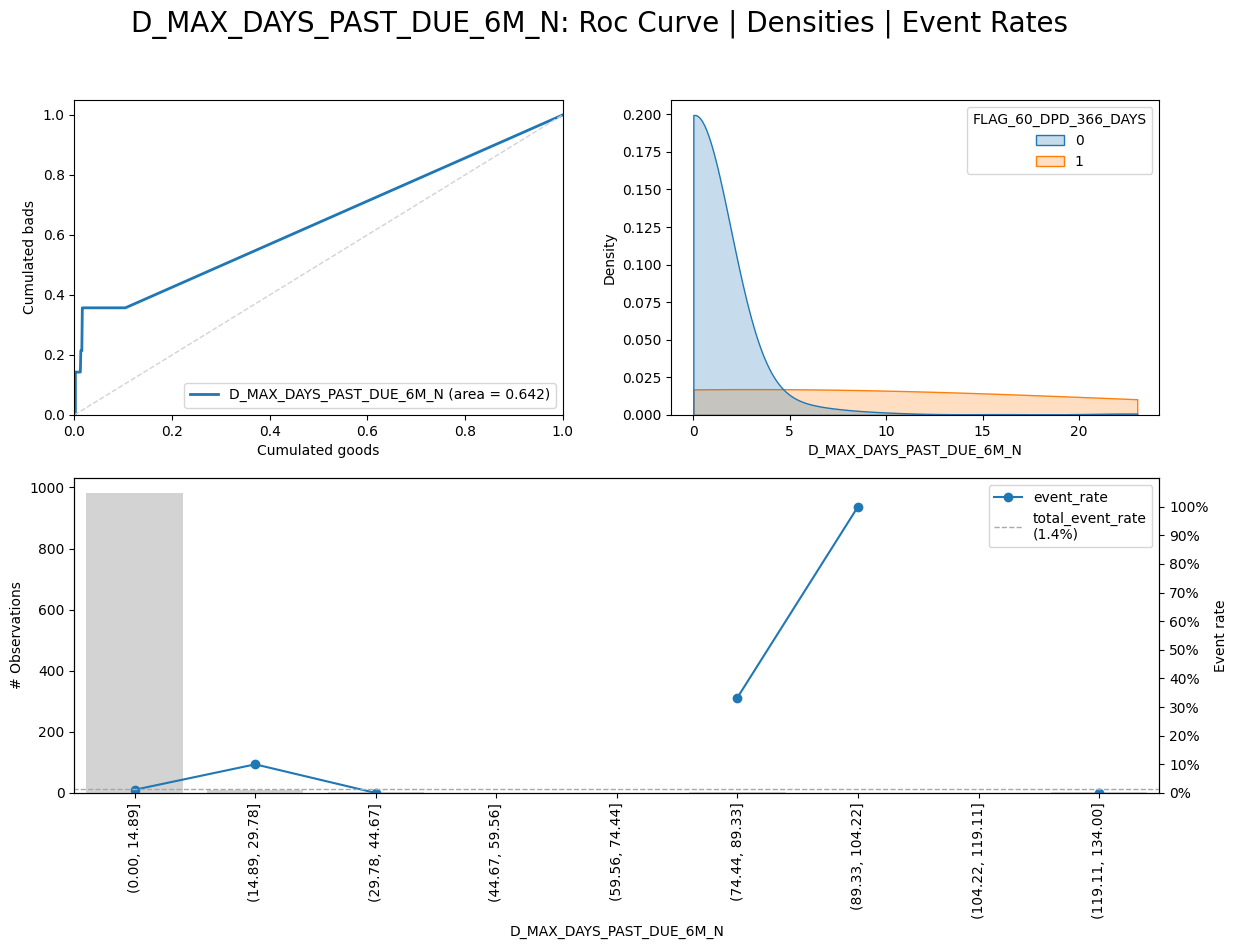

(      D_MAX_DAYS_PAST_DUE_6M_N_len  FLAG_60_DPD_366_DAYS_mean  lift_rate
 bins                                                                    
 0                              982                   0.011202   0.800116
 1                               10                   0.100000   7.142857
 2                                2                   0.000000   0.000000
 3                                0                        NaN        NaN
 4                                0                        NaN        NaN
 5                                3                   0.333333  23.809524
 6                                1                   1.000000  71.428571
 7                                0                        NaN        NaN
 8                                2                   0.000000   0.000000,
 <Figure size 1400x900 with 4 Axes>)

In [34]:
create_binary_target_plots(
    df = df_sample,
    target_col = "FLAG_60_DPD_366_DAYS",
    feature_col = "D_MAX_DAYS_PAST_DUE_6M_N",
    use_quantiles = False
)

currently here!
n_unique_feat_vals: 27
n_bins: 20
min: 0, max: 134
using quantiles
[  0.   1.   4. 134.]


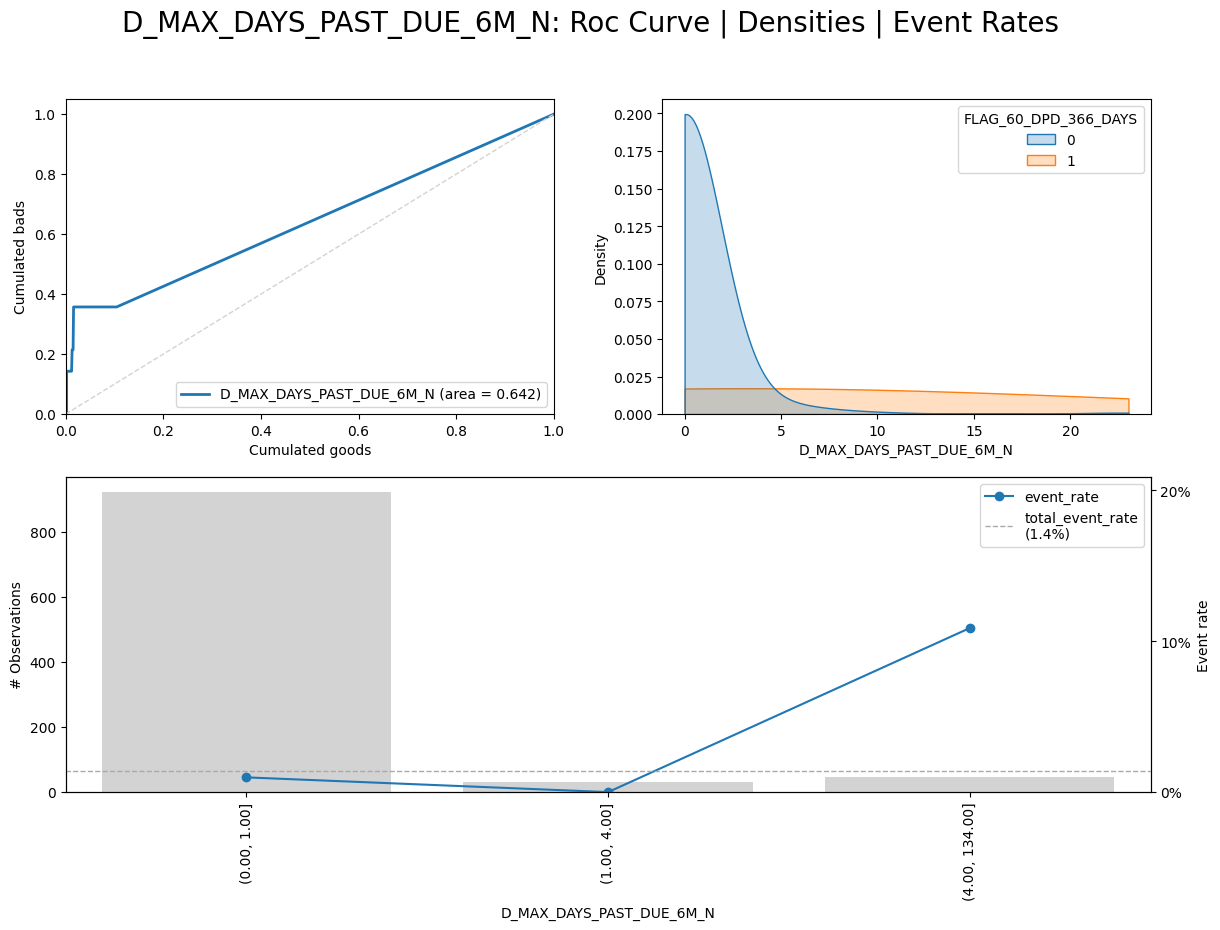

(      D_MAX_DAYS_PAST_DUE_6M_N_len  FLAG_60_DPD_366_DAYS_mean  lift_rate
 bins                                                                    
 0                              923                   0.009751   0.696487
 1                               31                   0.000000   0.000000
 2                               46                   0.108696   7.763975,
 <Figure size 1400x900 with 4 Axes>)

In [35]:
create_binary_target_plots(
    df = df_sample,
    target_col = "FLAG_60_DPD_366_DAYS",
    feature_col = "D_MAX_DAYS_PAST_DUE_6M_N",
    use_quantiles = True,
    n_bins=20
)